In [ ]:
import numpy as np

image_dateset = '../datasets/unlabelled_train_data_images.npy'
Xtrain_img = np.load(image_dateset)


In [ ]:
import numpy as np
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

def preprocess_and_cluster(X, n_components=50, n_clusters=10):
    """
    Preprocess image data and perform initial clustering
    Returns:
        - Cluster labels
        - PCA-transformed features
        - Cluster evaluation metrics
    """
    # Reshape to 2D array (samples, features)
    X_reshaped = X.reshape(X.shape[0], -1)
    
    # Dimensionality reduction
    pca = PCA(n_components=n_components, random_state=42)
    X_pca = pca.fit_transform(X_reshaped)
    
    # Clustering
    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
    cluster_labels = kmeans.fit_predict(X_pca)
    
    # Evaluation
    silhouette_avg = silhouette_score(X_pca, cluster_labels)
    
    # Visualization of first 2 principal components
    plt.figure(figsize=(10, 6))
    plt.scatter(X_pca[:, 0], X_pca[:, 1], c=cluster_labels, cmap='tab10', s=1)
    plt.title('Cluster Visualization in PCA Space')
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.colorbar()
    plt.show()
    
    return {
        'cluster_labels': cluster_labels,
        'transformed_features': X_pca,
        'silhouette_score': silhouette_avg,
        'pca_model': pca,
        'kmeans_model': kmeans
    }



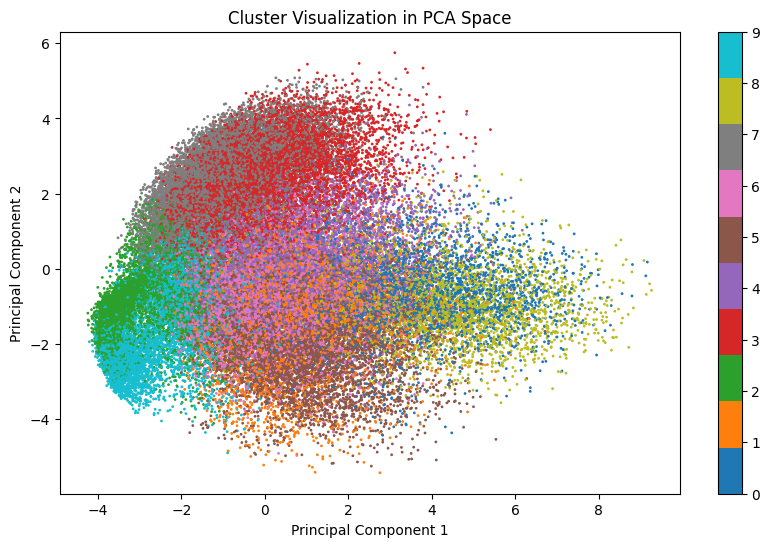

Silhouette Score: 0.085


In [3]:
clustering_results = preprocess_and_cluster(Xtrain_img)
print(f"Silhouette Score: {clustering_results['silhouette_score']:.3f}")

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans, DBSCAN
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score, davies_bouldin_score
from sklearn.model_selection import ParameterGrid

def preprocess_data(X, n_components=50):
    """Dimensionality reduction with PCA"""
    X_reshaped = X.reshape(X.shape[0], -1)
    pca = PCA(n_components=n_components, random_state=42)
    return pca.fit_transform(X_reshaped), pca

def cluster_analysis(X, method='gmm', params=None):
    """Perform clustering with different algorithms"""
    if method == 'gmm':
        model = GaussianMixture(**params, random_state=42)
        labels = model.fit_predict(X)
    elif method == 'dbscan':
        model = DBSCAN(**params)
        labels = model.fit_predict(X)
    elif method == 'kmeans':
        model = KMeans(**params, random_state=42, n_init=10)
        labels = model.fit_predict(X)
    return labels, model

def evaluate_clusters(X, labels):
    """Calculate clustering metrics"""
    if len(np.unique(labels)) < 2:
        return {'silhouette': -1, 'davies_bouldin': float('inf')}
    
    return {
        'silhouette': silhouette_score(X, labels),
        'davies_bouldin': davies_bouldin_score(X, labels)
    }

def visualize_clusters(X, labels, title='Cluster Visualization'):
    """Visualization using t-SNE"""
    tsne = TSNE(n_components=2, perplexity=30, random_state=42)
    X_tsne = tsne.fit_transform(X)
    
    plt.figure(figsize=(12, 8))
    scatter = plt.scatter(X_tsne[:, 0], X_tsne[:, 1], 
                         c=labels, cmap='tab20', s=5, alpha=0.6)
    plt.title(f'{title} (t-SNE)')
    plt.colorbar(scatter)
    plt.show()

def sample_cluster_images(X, labels, n_samples=10):
    """Visual inspection of cluster samples"""
    unique_labels = np.unique(labels)
    
    for label in unique_labels:
        if label == -1:  # Skip noise for DBSCAN
            continue
            
        plt.figure(figsize=(15, 2))
        plt.suptitle(f'Cluster {label}', y=1.05)
        
        cluster_data = X[labels == label]
        indices = np.random.choice(len(cluster_data), n_samples)
        
        for i, idx in enumerate(indices):
            plt.subplot(1, n_samples, i+1)
            plt.imshow(cluster_data[idx].reshape(28, 28), cmap='gray')
            plt.axis('off')
        plt.show()

def optimize_parameters(X, method='gmm', param_grid=None):
    """Hyperparameter tuning for clustering"""
    best_score = -1
    best_params = None
    
    for params in ParameterGrid(param_grid):
        try:
            labels, _ = cluster_analysis(X, method, params)
            score = evaluate_clusters(X, labels)['silhouette']
            
            if score > best_score:
                best_score = score
                best_params = params
        except:
            continue
    
    return best_params, best_score

# Execution Pipeline
def main_pipeline(X):
    # Step 1: Preprocessing
    X_pca, pca_model = preprocess_data(X)
    
    # Step 2: Parameter Optimization
    gmm_params = {
        'n_components': range(8, 15),
        'covariance_type': ['full', 'tied', 'diag']
    }
    
    best_gmm_params, gmm_score = optimize_parameters(
        X_pca, 'gmm', gmm_params
    )
    
    # Step 3: Final Clustering with Best Parameters
    final_labels, model = cluster_analysis(
        X_pca, 
        method='gmm',
        params=best_gmm_params
    )
    
    # Step 4: Evaluation
    metrics = evaluate_clusters(X_pca, final_labels)
    print(f"Silhouette: {metrics['silhouette']:.3f}")
    print(f"Davies-Bouldin: {metrics['davies_bouldin']:.3f}")
    
    # Step 5: Visualization
    visualize_clusters(X_pca, final_labels)
    sample_cluster_images(X, final_labels)
    
    return {
        'labels': final_labels,
        'model': model,
        'pca_model': pca_model,
        'metrics': metrics
    }

# Run the pipeline
if __name__ == "__main__":
    Xtrain_img = np.load(image_dateset) 
    results = main_pipeline(Xtrain_img)
    print(results)


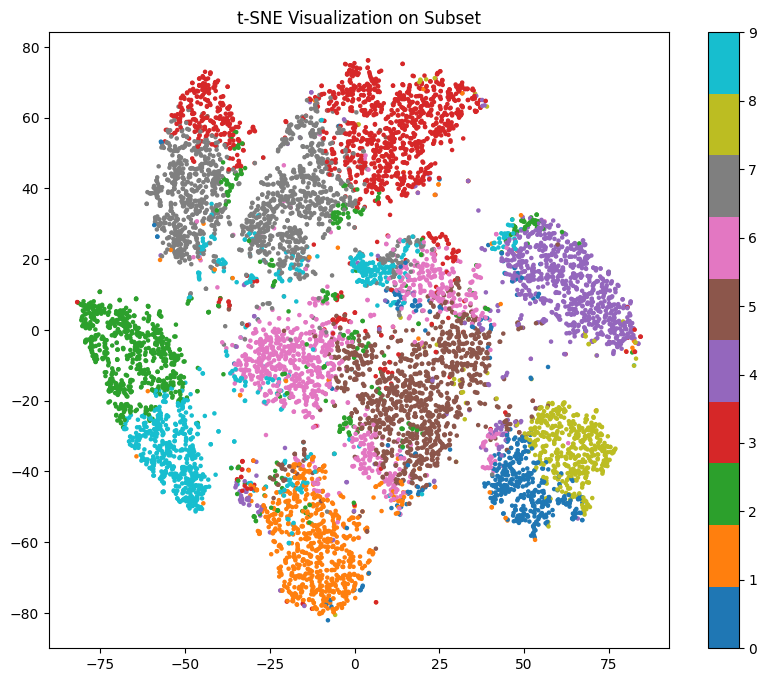

In [4]:
import numpy as np
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

def fast_tsne_visualization(X, labels, n_samples=2000):
    idx = np.random.choice(len(X), n_samples, replace=False)
    X_subset = X[idx].reshape(n_samples, -1)
    labels_subset = labels[idx]

    # Reduce to 50 dims with PCA
    X_pca = PCA(n_components=0.95, random_state=42).fit_transform(X_subset)
    # t-SNE on subset
    X_tsne = TSNE(n_components=2, perplexity=30, random_state=42).fit_transform(X_pca)

    plt.figure(figsize=(10, 8))
    plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=labels_subset, cmap='tab10', s=5)
    plt.title("t-SNE Visualization on Subset")
    plt.colorbar()
    plt.show()

from sklearn.mixture import GaussianMixture
from sklearn.cluster import KMeans

def get_final_labels(X, n_components_pca=50, n_clusters=10, method='gmm'):
    """
    Returns cluster labels for the image dataset using PCA + GMM/KMeans.
    
    Parameters:
        X (np.ndarray): Image data, shape (N, 1, 28, 28) or (N, 28, 28)
        n_components_pca (int): Number of PCA components
        n_clusters (int): Number of clusters/classes to find
        method (str): 'gmm' or 'kmeans'
        
    Returns:
        final_labels (np.ndarray): Cluster labels for each sample
        pca (PCA object): Fitted PCA model
        cluster_model: Fitted clustering model
        X_pca (np.ndarray): PCA-transformed features
    """
    # Flatten images
    if X.ndim == 4:
        X_flat = X.reshape(X.shape[0], -1)
    elif X.ndim == 3:
        X_flat = X.reshape(X.shape[0], -1)
    else:
        X_flat = X

    # PCA
    pca = PCA(n_components=n_components_pca, random_state=42)
    X_pca = pca.fit_transform(X_flat)
    
    # Clustering
    if method == 'gmm':
        cluster_model = GaussianMixture(n_components=n_clusters, random_state=42)
        final_labels = cluster_model.fit_predict(X_pca)
    elif method == 'kmeans':
        cluster_model = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
        final_labels = cluster_model.fit_predict(X_pca)
    else:
        raise ValueError("method must be 'gmm' or 'kmeans'")
    
    return final_labels, pca, cluster_model, X_pca

# Load your image data
Xtrain_img = np.load(image_dateset) 

# Get labels using GMM
# final_labels, pca, cluster_model, X_pca = get_final_labels(Xtrain_img, n_components_pca=50, n_clusters=10, method='gmm')

# (Optional) To use KMeans instead:
final_labels, pca, cluster_model, X_pca = get_final_labels(Xtrain_img, n_components_pca=50, n_clusters=10, method='kmeans')


fast_tsne_visualization(Xtrain_img, final_labels, n_samples=10000)